# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

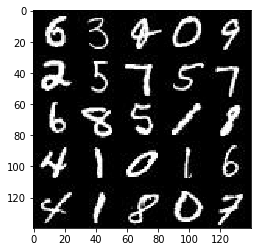

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

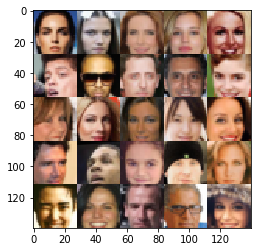

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
#         input 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, alpha * x1)
#         14x14x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha * x3)
#         7x7x256 

        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(x4, alpha * x4)
#         7x7x512 

        flat = tf.reshape(x4, (-1, 7 * 7 * 512))
        logits = tf.layers.dense(flat, 1)        
        
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 512, activation=None)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha * x1)
#         7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
#         14x14x128

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, alpha * x4)
#         28x28x64

#         28x28x out_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
#                 *=2 for matching generator
                batch_images *= 2
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 6.9350
Epoch 1/2... Discriminator Loss: 3.7473... Generator Loss: 6.2713
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 2.4317... Generator Loss: 0.2460
Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 2.1665... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 2.3763... Generator Loss: 0.2493
Epoch 1/2... Discriminator Loss: 2.1315... Generator Loss: 0.3021
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.3998
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 0.4219


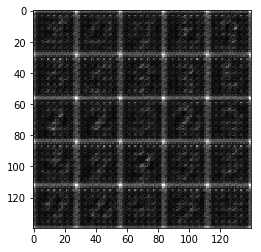

Epoch 1/2... Discriminator Loss: 1.7463... Generator Loss: 0.4501
Epoch 1/2... Discriminator Loss: 1.6333... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 2.0729... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 1.7001... Generator Loss: 0.3475
Epoch 1/2... Discriminator Loss: 2.4206... Generator Loss: 0.1831
Epoch 1/2... Discriminator Loss: 2.2234... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.8362... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 2.0519... Generator Loss: 0.2397


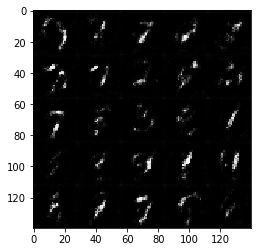

Epoch 1/2... Discriminator Loss: 2.1931... Generator Loss: 0.2231
Epoch 1/2... Discriminator Loss: 2.1900... Generator Loss: 0.2284
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 1.9942... Generator Loss: 0.3305
Epoch 1/2... Discriminator Loss: 1.9385... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 0.7967... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.7297
Epoch 1/2... Discriminator Loss: 2.1313... Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 1.1323


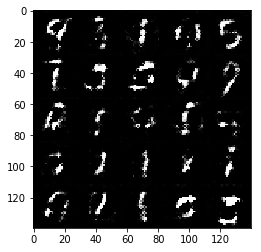

Epoch 1/2... Discriminator Loss: 1.8046... Generator Loss: 0.3442
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 1.6679... Generator Loss: 2.0662
Epoch 1/2... Discriminator Loss: 1.8293... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 1.1876
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 1.1464


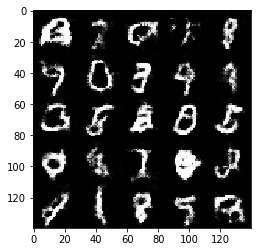

Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.7145... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 2.3317... Generator Loss: 0.2147
Epoch 1/2... Discriminator Loss: 2.3190... Generator Loss: 0.2409
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 1.4871


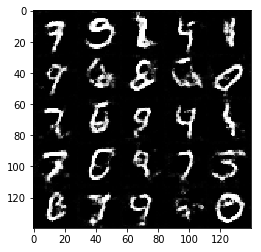

Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 1.9544... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 2.3472
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.9342... Generator Loss: 2.2626
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 1.5240


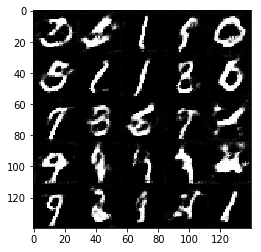

Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 1.8475
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 2.2993... Generator Loss: 0.1951
Epoch 2/2... Discriminator Loss: 1.7795... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 1.5934... Generator Loss: 0.4703
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 0.9937


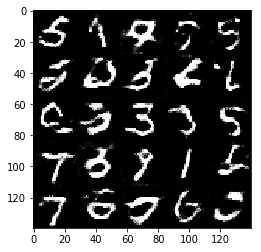

Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 1.6599
Epoch 2/2... Discriminator Loss: 1.6627... Generator Loss: 1.9485
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 1.5746
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.4688... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.6823... Generator Loss: 0.3627
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.7128


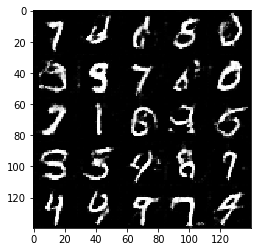

Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 1.1982
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 1.5413... Generator Loss: 0.4079
Epoch 2/2... Discriminator Loss: 1.5586... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 1.9846... Generator Loss: 0.2960
Epoch 2/2... Discriminator Loss: 1.9542... Generator Loss: 0.2865
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 1.2532


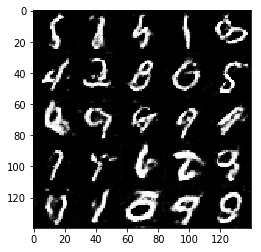

Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 1.4837... Generator Loss: 1.6543
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.6940


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4907... Generator Loss: 12.0098
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 2.0005
Epoch 1/1... Discriminator Loss: 3.4427... Generator Loss: 6.1931
Epoch 1/1... Discriminator Loss: 1.8868... Generator Loss: 4.2823
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 4.2158
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 2.8407
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 3.1315
Epoch 1/1... Discriminator Loss: 2.8849... Generator Loss: 4.5632
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 2.9296
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 2.5982


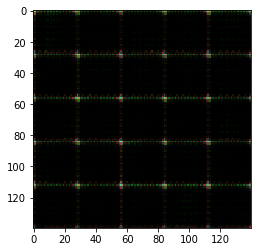

Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 2.6554
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.8850
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 1.8229
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 2.3840
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.4500
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4822


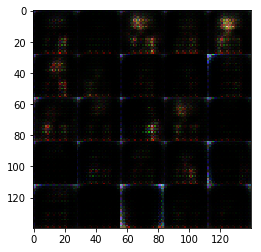

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 2.0323
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 2.0334
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 2.2728... Generator Loss: 0.1834


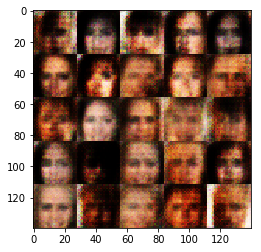

Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.2998
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 1.6737
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 2.3048


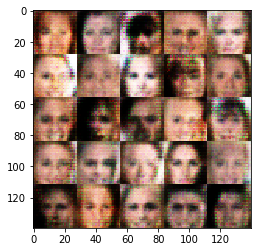

Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 2.6461
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 2.5277... Generator Loss: 0.1394
Epoch 1/1... Discriminator Loss: 1.8163... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 0.3143
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.8181
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6096


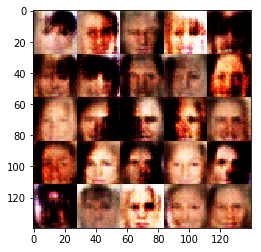

Epoch 1/1... Discriminator Loss: 1.8106... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.6255
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.5965
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 2.3646
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9144


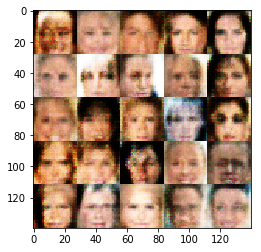

Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 2.1736... Generator Loss: 4.2819
Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 2.6968


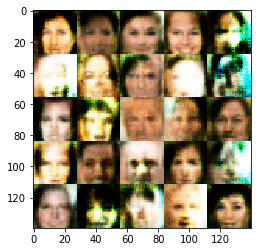

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9132


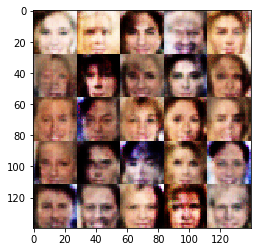

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 2.5166
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.3368


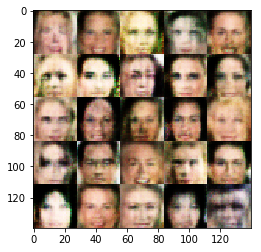

Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 2.2217
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 3.5266
Epoch 1/1... Discriminator Loss: 2.2233... Generator Loss: 1.9708


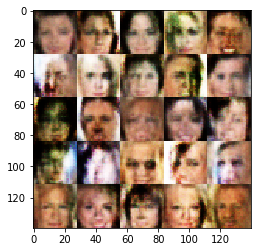

Epoch 1/1... Discriminator Loss: 1.7007... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 2.3887
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.2482


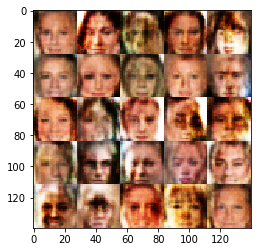

Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 2.0247... Generator Loss: 4.3908
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.7626


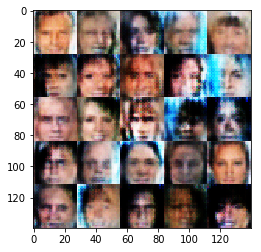

Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.5551


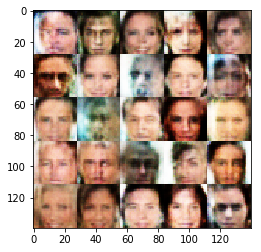

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.6747
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.3560


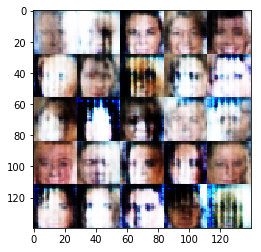

Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.9286
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6274


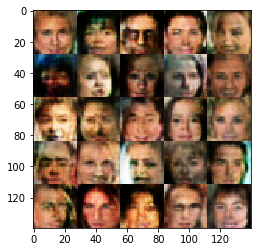

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 2.3331
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.5954


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.